# Optimización de Ubicación de Sensores LoRa
## Set Cover Problem mediante Programación Lineal Entera (PLE)

**Objetivo:** Minimizar el número de nodos sensores requeridos ($N_{\text{óptimo}}$) para garantizar el 100% de cobertura en un campo rectangular considerando interferencia y obstrucciones.

**Modelo de propagación:** Path-loss con diferenciación entre campo abierto y obstruido

---

## 1. Carga de Configuración y Librerías

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge
from pulp import *
from datetime import datetime

# Configurar matplotlib para mejor visualización
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['font.size'] = 10

print("Librerías cargadas exitosamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Librerías cargadas exitosamente
Fecha de ejecución: 2025-11-14 23:01:35


In [2]:
# Cargar configuración desde archivo JSON
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

# Extraer parámetros del campo
L_x = config['campo']['dimension_x_m']
L_y = config['campo']['dimension_y_m']
C_x = config['discretizacion']['celda_x_m']
C_y = config['discretizacion']['celda_y_m']
A_total = config['campo']['area_total_m2']

# Extraer parámetros de propagación
freq_mhz = config['propagacion']['frecuencia_mhz']
P_tx_dbm = config['propagacion']['potencia_tx_dbm']
sens_rx_dbm = config['propagacion']['sensibilidad_rx_dbm']
n_abierto = config['propagacion']['exponente_path_loss_abierto']
n_obstruido = config['propagacion']['exponente_path_loss_obstruido']
PL_ref_db = config['propagacion']['perdida_referencia_1m_db']
margen_db = config['propagacion']['margen_desvanecimiento_db']

# Parámetros del escenario
porcentaje_obstruido = config['escenario']['porcentaje_area_obstruida']

print("=" * 70)
print("PARÁMETROS DEL PROBLEMA")
print("=" * 70)
print(f"Área del campo: {A_total:,.2f} m²")
print(f"Dimensiones del campo: {L_x} m × {L_y} m")
print(f"Tamaño de celda: {C_x} m × {C_y} m")
print(f"\nModelo de propagación: Path-Loss")
print(f"Frecuencia LoRa: {freq_mhz} MHz")
print(f"Potencia TX: {P_tx_dbm} dBm")
print(f"Sensibilidad RX: {sens_rx_dbm} dBm")
print(f"Exponente path-loss (abierto): {n_abierto}")
print(f"Exponente path-loss (obstruido): {n_obstruido}")
print(f"Margen de desvanecimiento: {margen_db} dB")
print(f"\nEscenario: {config['escenario']['tipo']}")
print(f"Porcentaje área obstruida: {porcentaje_obstruido}%")
print("=" * 70)

PARÁMETROS DEL PROBLEMA
Área del campo: 2,080,000.00 m²
Dimensiones del campo: 2000 m × 1040 m
Tamaño de celda: 50 m × 50 m

Modelo de propagación: Path-Loss
Frecuencia LoRa: 915 MHz
Potencia TX: 14 dBm
Sensibilidad RX: -137 dBm
Exponente path-loss (abierto): 2.0
Exponente path-loss (obstruido): 3.5
Margen de desvanecimiento: 10 dB

Escenario: zona_campesina_poblada
Porcentaje área obstruida: 35%


## 2. Generación del Conjunto J (Puntos de Demanda)

In [3]:
# Generar puntos centrales de las celdas (Conjunto J)
J = []
j_index = 0

# Comenzar en (C_x/2, C_y/2) y avanzar en pasos de C_x y C_y
y = C_y / 2
while y < L_y:
    x = C_x / 2
    while x < L_x:
        J.append((j_index, x, y))
        j_index += 1
        x += C_x
    y += C_y

# Convertir a array de numpy para facilitar cálculos
J_coords = np.array([(x, y) for _, x, y in J])

print(f"Número de puntos de demanda (|J|): {len(J)}")
print(f"\nPrimeros 5 puntos de demanda:")
for i in range(min(5, len(J))):
    idx, x, y = J[i]
    print(f"  J[{idx}] = ({x:.1f}, {y:.1f})")
print(f"\nÚltimos 3 puntos de demanda:")
for i in range(max(0, len(J)-3), len(J)):
    idx, x, y = J[i]
    print(f"  J[{idx}] = ({x:.1f}, {y:.1f})")

Número de puntos de demanda (|J|): 840

Primeros 5 puntos de demanda:
  J[0] = (25.0, 25.0)
  J[1] = (75.0, 25.0)
  J[2] = (125.0, 25.0)
  J[3] = (175.0, 25.0)
  J[4] = (225.0, 25.0)

Últimos 3 puntos de demanda:
  J[837] = (1875.0, 1025.0)
  J[838] = (1925.0, 1025.0)
  J[839] = (1975.0, 1025.0)


## 3. Generación del Conjunto I (Posibles Ubicaciones de Sensores)

In [4]:
# Para este problema, asumimos que I = J
# (las posibles ubicaciones coinciden con los centros de las celdas)
I = J.copy()
I_coords = J_coords.copy()

print(f"Número de posibles ubicaciones de sensores (|I|): {len(I)}")
print(f"Nota: En este caso, I = J (ubicaciones coinciden con centros de celdas)")

Número de posibles ubicaciones de sensores (|I|): 840
Nota: En este caso, I = J (ubicaciones coinciden con centros de celdas)


## 4. Modelo de Propagación Path-Loss

In [5]:
def calcular_path_loss(distancia_m, n, d0=1.0):
    """
    Calcula la pérdida por trayectoria (path-loss) en dB.
    
    PL(d) = PL(d0) + 10 * n * log10(d/d0)
    
    Args:
        distancia_m: Distancia en metros
        n: Exponente de path-loss (2.0 para campo abierto, 3.5 para obstruido)
        d0: Distancia de referencia (1 metro)
    
    Returns:
        Pérdida en dB
    """
    if distancia_m < d0:
        distancia_m = d0
    return PL_ref_db + 10 * n * np.log10(distancia_m / d0)

def calcular_rango_maximo(n):
    """
    Calcula el rango máximo de comunicación dado un exponente de path-loss.
    
    P_rx = P_tx - PL(d)
    P_rx >= Sens_rx + Margen
    
    Args:
        n: Exponente de path-loss
    
    Returns:
        Rango máximo en metros
    """
    # Budget de enlace disponible
    link_budget = P_tx_dbm - sens_rx_dbm - margen_db
    
    # PL(d) = PL_ref + 10*n*log10(d)
    # link_budget = PL_ref + 10*n*log10(d_max)
    # log10(d_max) = (link_budget - PL_ref) / (10*n)
    
    d_max = 10 ** ((link_budget - PL_ref_db) / (10 * n))
    return d_max

def link_es_viable(distancia_m, es_obstruido):
    """
    Determina si un enlace es viable dada la distancia y condición de obstrucción.
    
    Args:
        distancia_m: Distancia en metros
        es_obstruido: True si el enlace está obstruido, False si es campo abierto
    
    Returns:
        True si el enlace es viable, False en caso contrario
    """
    n = n_obstruido if es_obstruido else n_abierto
    path_loss = calcular_path_loss(distancia_m, n)
    potencia_recibida = P_tx_dbm - path_loss
    umbral = sens_rx_dbm + margen_db
    return potencia_recibida >= umbral

# Calcular rangos máximos
R_abierto = calcular_rango_maximo(n_abierto)
R_obstruido = calcular_rango_maximo(n_obstruido)

print("Modelo de Path-Loss configurado:")
print(f"\nBudget de enlace total: {P_tx_dbm - sens_rx_dbm:.1f} dB")
print(f"Budget disponible (con margen): {P_tx_dbm - sens_rx_dbm - margen_db:.1f} dB")
print(f"\nRango máximo en campo abierto (n={n_abierto}): {R_abierto:.1f} m")
print(f"Rango máximo en zona obstruida (n={n_obstruido}): {R_obstruido:.1f} m")
print(f"\nReducción de rango por obstrucción: {100*(1-R_obstruido/R_abierto):.1f}%")

Modelo de Path-Loss configurado:

Budget de enlace total: 151.0 dB
Budget disponible (con margen): 141.0 dB

Rango máximo en campo abierto (n=2.0): 109647.8 m
Rango máximo en zona obstruida (n=3.5): 758.6 m

Reducción de rango por obstrucción: 99.3%


## 5. Cálculo de la Matriz de Cobertura con Path-Loss

In [6]:
def calcular_distancia(p1, p2):
    """Calcula la distancia euclidiana entre dos puntos."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Crear matriz de cobertura a_ij considerando path-loss
print("Calculando matriz de cobertura con modelo de path-loss...")
print(f"Probabilidad de obstrucción: {porcentaje_obstruido}%\n")

n_I = len(I)
n_J = len(J)
a = np.zeros((n_I, n_J), dtype=int)

# Para reproducibilidad, fijar semilla aleatoria
np.random.seed(42)

# Matriz para rastrear cuáles enlaces son obstruidos (para visualización)
enlaces_obstruidos = np.random.rand(n_I, n_J) < (porcentaje_obstruido / 100.0)

enlaces_totales = 0
enlaces_viables_abierto = 0
enlaces_viables_obstruido = 0

for i in range(n_I):
    for j in range(n_J):
        dist = calcular_distancia(I_coords[i], J_coords[j])
        es_obstruido = enlaces_obstruidos[i, j]
        
        if link_es_viable(dist, es_obstruido):
            a[i, j] = 1
            if es_obstruido:
                enlaces_viables_obstruido += 1
            else:
                enlaces_viables_abierto += 1
        
        enlaces_totales += 1

print(f"Matriz de cobertura calculada: {n_I} × {n_J}")
print(f"\nEstadísticas de enlaces:")
print(f"  Total de enlaces posibles: {enlaces_totales:,}")
print(f"  Enlaces viables (campo abierto): {enlaces_viables_abierto:,}")
print(f"  Enlaces viables (obstruidos): {enlaces_viables_obstruido:,}")
print(f"  Total enlaces viables: {np.sum(a):,}")
print(f"  Densidad de cobertura: {100 * np.sum(a) / enlaces_totales:.2f}%")

# Mostrar ejemplo de una fila de la matriz
print(f"\nEjemplo - Fila 0 (ubicación I[0] = {I_coords[0]}):")
puntos_cubiertos = np.where(a[0] == 1)[0]
print(f"  Cubre {len(puntos_cubiertos)} puntos de demanda")
print(f"  Primeros 10 índices cubiertos: {puntos_cubiertos[:10].tolist()}")

# Verificar que cada punto de demanda puede ser cubierto por al menos un sensor
puntos_sin_cobertura = np.where(np.sum(a, axis=0) == 0)[0]
if len(puntos_sin_cobertura) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(puntos_sin_cobertura)} puntos de demanda no pueden ser cubiertos")
    print(f"   Considere aumentar la potencia TX o reducir el margen de desvanecimiento")
else:
    print(f"\n✓ Todos los puntos de demanda pueden ser cubiertos por al menos un sensor")

Calculando matriz de cobertura con modelo de path-loss...
Probabilidad de obstrucción: 35%



Matriz de cobertura calculada: 840 × 840

Estadísticas de enlaces:
  Total de enlaces posibles: 705,600
  Enlaces viables (campo abierto): 458,829
  Enlaces viables (obstruidos): 122,715
  Total enlaces viables: 581,544
  Densidad de cobertura: 82.42%

Ejemplo - Fila 0 (ubicación I[0] = [25. 25.]):
  Cubre 611 puntos de demanda
  Primeros 10 índices cubiertos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

✓ Todos los puntos de demanda pueden ser cubiertos por al menos un sensor


## 6. Formulación del Problema de PLE con PuLP

In [7]:
print("Formulando el problema de optimización...\n")

# Crear el problema de minimización
prob = LpProblem("Set_Cover_Sensor_Optimization_PathLoss", LpMinimize)

# Variables de decisión: x_i ∈ {0, 1} para cada ubicación i ∈ I
x = {}
for i in range(n_I):
    x[i] = LpVariable(f"x_{i}", cat='Binary')

# Función objetivo: Minimizar Σ x_i
prob += lpSum([x[i] for i in range(n_I)]), "Minimizar_numero_de_sensores"

# Restricciones de cobertura: Σ a_ij * x_i ≥ 1 para todo j ∈ J
for j in range(n_J):
    prob += lpSum([a[i, j] * x[i] for i in range(n_I)]) >= 1, f"Cobertura_punto_{j}"

print("Problema formulado:")
print(f"  Variables de decisión: {n_I}")
print(f"  Restricciones de cobertura: {n_J}")
print(f"  Función objetivo: Minimizar Σ x_i")
print(f"  Modelo: Path-loss con {porcentaje_obstruido}% de obstrucción")

Formulando el problema de optimización...



Problema formulado:
  Variables de decisión: 840
  Restricciones de cobertura: 840
  Función objetivo: Minimizar Σ x_i
  Modelo: Path-loss con 35% de obstrucción


## 7. Resolución del Problema y Extracción de Resultados

In [8]:
print("Resolviendo el problema de optimización...\n")
print("Esto puede tomar algunos minutos dependiendo del tamaño del problema.\n")

# Resolver el problema
inicio = datetime.now()
prob.solve(PULP_CBC_CMD(msg=1))
fin = datetime.now()
tiempo_resolucion = (fin - inicio).total_seconds()

# Verificar el estado de la solución
print("\n" + "=" * 70)
print("RESULTADOS DE LA OPTIMIZACIÓN")
print("=" * 70)
print(f"Estado de la solución: {LpStatus[prob.status]}")
print(f"Tiempo de resolución: {tiempo_resolucion:.2f} segundos")

if prob.status == LpStatusOptimal:
    # Extraer la solución óptima
    N_optimo = int(value(prob.objective))
    sensores_optimos = []
    
    for i in range(n_I):
        if x[i].varValue == 1:
            sensores_optimos.append(i)
    
    # Obtener coordenadas de los sensores óptimos
    coordenadas_optimas = [(I_coords[i][0], I_coords[i][1]) for i in sensores_optimos]
    
    print(f"\n✓ Solución óptima encontrada")
    print(f"\nN_óptimo = {N_optimo} sensores (con modelo path-loss)")
    print(f"\nCoordenadas de los sensores óptimos:")
    print("-" * 50)
    for idx, sensor_i in enumerate(sensores_optimos, 1):
        x_coord, y_coord = coordenadas_optimas[idx-1]
        print(f"  Sensor {idx:2d}: ({x_coord:6.1f}, {y_coord:6.1f}) [índice I={sensor_i}]")
    
    # Calcular métricas adicionales
    densidad_sensores = N_optimo / (A_total / 10000)  # sensores por hectárea
    area_por_sensor = A_total / N_optimo
    
    print(f"\nMétricas adicionales:")
    print(f"  Densidad de sensores: {densidad_sensores:.2f} sensores/hectárea")
    print(f"  Área promedio por sensor: {area_por_sensor:,.2f} m²")
    print(f"  Porcentaje de ubicaciones utilizadas: {100*N_optimo/n_I:.2f}%")
    print(f"  Área de cobertura (abierto): {np.pi * R_abierto**2:,.2f} m²")
    print(f"  Área de cobertura (obstruido): {np.pi * R_obstruido**2:,.2f} m²")
    
else:
    print(f"\n⚠️ No se encontró una solución óptima")
    print(f"Estado: {LpStatus[prob.status]}")
    N_optimo = None
    sensores_optimos = []
    coordenadas_optimas = []

Resolviendo el problema de optimización...

Esto puede tomar algunos minutos dependiendo del tamaño del problema.



Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/usuario/code/GIT/set-cover-problem/venv/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/x7/yqjxlcpn6896ntpm60n8wg4r0000gn/T/093549e11b0f4e279910ead927180035-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/x7/yqjxlcpn6896ntpm60n8wg4r0000gn/T/093549e11b0f4e279910ead927180035-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 845 COLUMNS
At line 584910 RHS
At line 585751 BOUNDS
At line 586592 ENDATA
Problem MODEL has 840 rows, 840 columns and 581544 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.22979 - 0.98 seconds
Cgl0004I processed model has 840 rows, 840 columns (840 integer (840 of which binary)) and 581544 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 225 integers unsatisfied sum - 

## 8. Visualización con Matplotlib


✓ Visualización guardada como 'distribucion_sensores_pathloss.png'


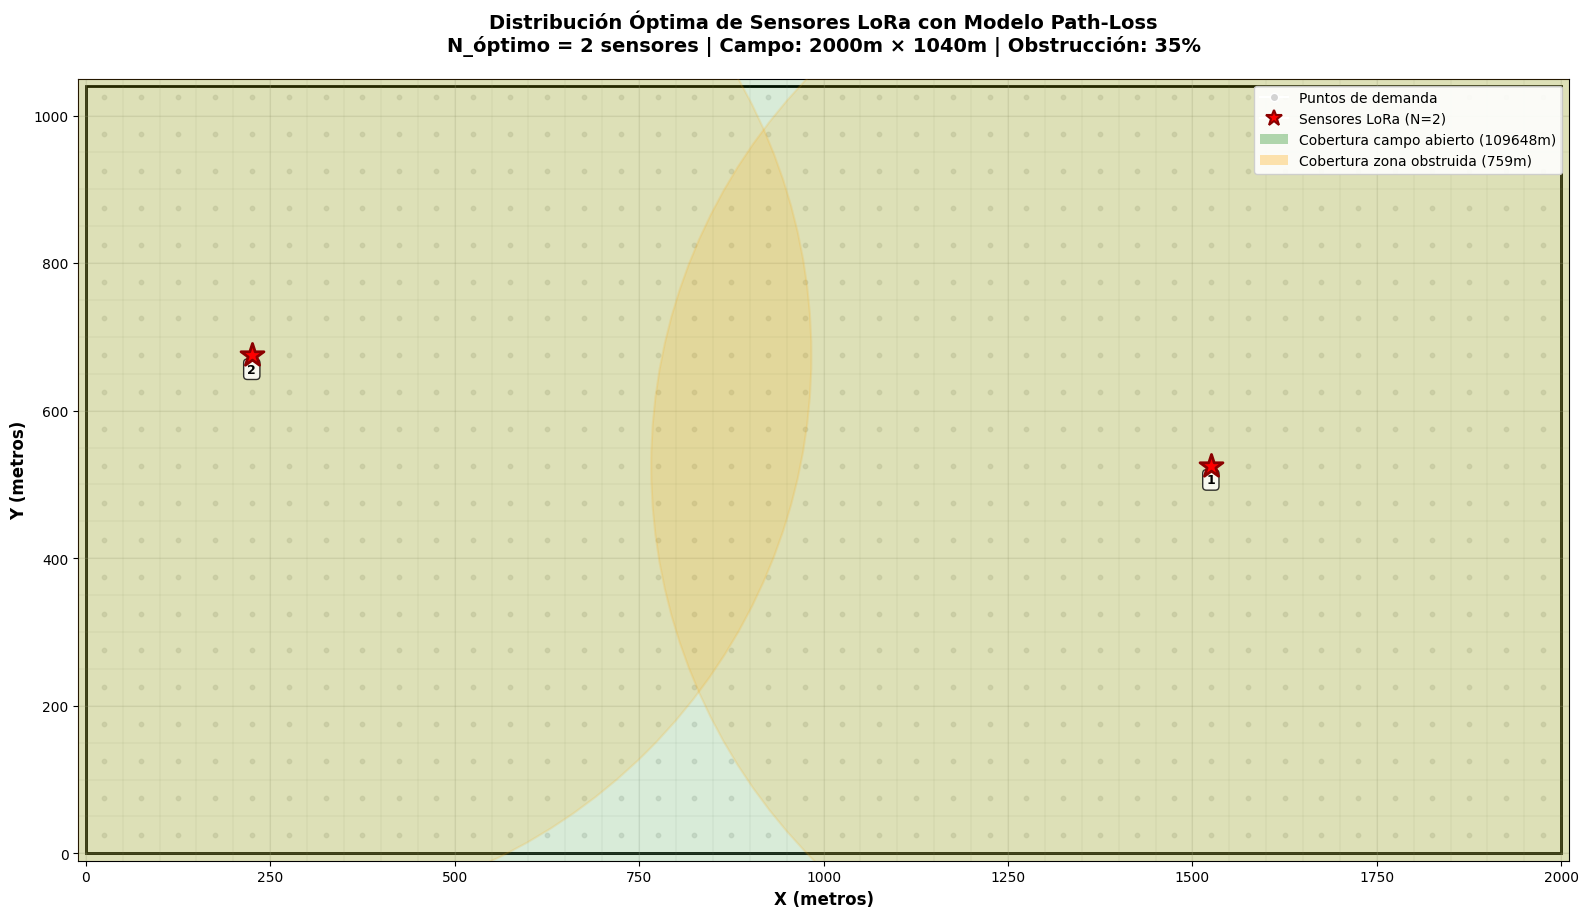

In [9]:
if N_optimo is not None:
    fig, ax = plt.subplots(figsize=(16, 13))
    
    # Configurar límites del gráfico
    ax.set_xlim(-10, L_x + 10)
    ax.set_ylim(-10, L_y + 10)
    ax.set_aspect('equal')
    
    # Dibujar el contorno del campo
    ax.add_patch(plt.Rectangle((0, 0), L_x, L_y, 
                                fill=False, edgecolor='black', linewidth=2))
    
    # Dibujar grid de celdas si está configurado
    if config['visualizacion']['mostrar_grid']:
        for x_grid in np.arange(0, L_x + C_x, C_x):
            ax.axvline(x=x_grid, color='gray', linewidth=0.3, alpha=0.3)
        for y_grid in np.arange(0, L_y + C_y, C_y):
            ax.axhline(y=y_grid, color='gray', linewidth=0.3, alpha=0.3)
    
    # Dibujar puntos de demanda (todos)
    ax.scatter(J_coords[:, 0], J_coords[:, 1], 
               c='lightgray', s=10, alpha=0.5, label='Puntos de demanda', zorder=1)
    
    # Dibujar círculos de cobertura si está configurado
    if config['visualizacion']['mostrar_circulos_cobertura']:
        for x_s, y_s in coordenadas_optimas:
            # Círculo de cobertura en campo abierto (más grande, transparente)
            circle_abierto = Circle((x_s, y_s), R_abierto, 
                                   color='green', alpha=0.08, linestyle='--',
                                   fill=True, linewidth=1, zorder=2)
            ax.add_patch(circle_abierto)
            
            # Círculo de cobertura en zona obstruida (más pequeño, más visible)
            circle_obstruido = Circle((x_s, y_s), R_obstruido, 
                                     color='orange', alpha=0.15, linestyle='-',
                                     fill=True, linewidth=1.5, zorder=3)
            ax.add_patch(circle_obstruido)
    
    # Dibujar sensores óptimos
    sensores_x = [coord[0] for coord in coordenadas_optimas]
    sensores_y = [coord[1] for coord in coordenadas_optimas]
    ax.scatter(sensores_x, sensores_y, 
               c='red', 
               s=300, marker='*', 
               edgecolors='darkred', linewidth=2,
               label=f'Sensores LoRa (N={N_optimo})', zorder=5)
    
    # Agregar números a los sensores
    for idx, (x_s, y_s) in enumerate(coordenadas_optimas, 1):
        ax.text(x_s, y_s - 10, str(idx), 
               ha='center', va='top', fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Crear leyenda personalizada para los rangos
    from matplotlib.patches import Patch
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', 
                   markersize=6, label='Puntos de demanda'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', 
                   markeredgecolor='darkred', markeredgewidth=1.5,
                   markersize=12, label=f'Sensores LoRa (N={N_optimo})'),
        Patch(facecolor='green', alpha=0.3, linestyle='--',
              label=f'Cobertura campo abierto ({R_abierto:.0f}m)'),
        Patch(facecolor='orange', alpha=0.3,
              label=f'Cobertura zona obstruida ({R_obstruido:.0f}m)')
    ]
    
    # Configurar título y etiquetas
    ax.set_xlabel('X (metros)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y (metros)', fontsize=12, fontweight='bold')
    titulo = f"Distribución Óptima de Sensores LoRa con Modelo Path-Loss\n"
    titulo += f"N_óptimo = {N_optimo} sensores | Campo: {L_x}m × {L_y}m | "
    titulo += f"Obstrucción: {porcentaje_obstruido}%"
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=20)
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.savefig('distribucion_sensores_pathloss.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualización guardada como 'distribucion_sensores_pathloss.png'")
    plt.show()
else:
    print("No se puede generar visualización sin solución óptima")

## 9. Generación de Reporte Detallado

In [10]:
if config['reporte']['generar_reporte_detallado'] and N_optimo is not None:
    nombre_reporte = config['reporte']['nombre_archivo']
    
    with open(nombre_reporte, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("REPORTE DE OPTIMIZACIÓN DE SENSORES LoRa CON MODELO PATH-LOSS\n")
        f.write("Set Cover Problem - Programación Lineal Entera\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Fecha de generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("-"*80 + "\n")
        f.write("1. PARÁMETROS DEL PROBLEMA\n")
        f.write("-"*80 + "\n")
        f.write(f"Área total del campo: {A_total:,.2f} m²\n")
        f.write(f"Dimensiones del campo: {L_x} m × {L_y} m\n")
        f.write(f"Tamaño de celda de discretización: {C_x} m × {C_y} m\n")
        f.write(f"Número de puntos de demanda (|J|): {len(J)}\n")
        f.write(f"Número de posibles ubicaciones (|I|): {len(I)}\n\n")
        
        f.write("-"*80 + "\n")
        f.write("2. MODELO DE PROPAGACIÓN PATH-LOSS\n")
        f.write("-"*80 + "\n")
        f.write(f"Frecuencia: {freq_mhz} MHz\n")
        f.write(f"Potencia de transmisión: {P_tx_dbm} dBm\n")
        f.write(f"Sensibilidad del receptor: {sens_rx_dbm} dBm\n")
        f.write(f"Pérdida de referencia (1m): {PL_ref_db} dB\n")
        f.write(f"Margen de desvanecimiento: {margen_db} dB\n")
        f.write(f"Exponente path-loss (campo abierto): {n_abierto}\n")
        f.write(f"Exponente path-loss (zona obstruida): {n_obstruido}\n")
        f.write(f"\nRango máximo (campo abierto): {R_abierto:.2f} m\n")
        f.write(f"Rango máximo (zona obstruida): {R_obstruido:.2f} m\n")
        f.write(f"Reducción de rango: {100*(1-R_obstruido/R_abierto):.1f}%\n\n")
        
        f.write("-"*80 + "\n")
        f.write("3. ESCENARIO DE INTERFERENCIA\n")
        f.write("-"*80 + "\n")
        f.write(f"Tipo de escenario: {config['escenario']['tipo']}\n")
        f.write(f"Porcentaje de área obstruida: {porcentaje_obstruido}%\n")
        f.write(f"Patrón de obstrucción: {config['escenario']['patron_obstruccion']}\n\n")
        
        f.write("-"*80 + "\n")
        f.write("4. FORMULACIÓN MATEMÁTICA\n")
        f.write("-"*80 + "\n")
        f.write("Función Objetivo:\n")
        f.write("  Minimizar: Σ x_i  (para todo i ∈ I)\n\n")
        f.write("Restricciones:\n")
        f.write("  Σ a_ij * x_i ≥ 1  (para todo j ∈ J)\n")
        f.write("  x_i ∈ {0, 1}      (para todo i ∈ I)\n\n")
        f.write("Donde a_ij = 1 si el enlace (i,j) es viable según modelo path-loss\n\n")
        
        f.write("-"*80 + "\n")
        f.write("5. RESULTADOS DE LA OPTIMIZACIÓN\n")
        f.write("-"*80 + "\n")
        f.write(f"Estado de la solución: {LpStatus[prob.status]}\n")
        f.write(f"Tiempo de resolución: {tiempo_resolucion:.2f} segundos\n")
        f.write(f"Solver utilizado: PULP_CBC_CMD\n\n")
        f.write(f"N_óptimo (número mínimo de sensores): {N_optimo}\n\n")
        
        f.write("-"*80 + "\n")
        f.write("6. COORDENADAS DE LOS SENSORES ÓPTIMOS\n")
        f.write("-"*80 + "\n")
        f.write(f"{'Sensor':<10} {'X (m)':<12} {'Y (m)':<12} {'Índice I':<10}\n")
        f.write("-"*80 + "\n")
        for idx, sensor_i in enumerate(sensores_optimos, 1):
            x_coord, y_coord = coordenadas_optimas[idx-1]
            f.write(f"{idx:<10} {x_coord:<12.2f} {y_coord:<12.2f} {sensor_i:<10}\n")
        f.write("\n")
        
        f.write("-"*80 + "\n")
        f.write("7. MÉTRICAS Y ESTADÍSTICAS\n")
        f.write("-"*80 + "\n")
        f.write(f"Densidad de sensores: {densidad_sensores:.4f} sensores/hectárea\n")
        f.write(f"Área promedio cubierta por sensor: {area_por_sensor:,.2f} m²\n")
        f.write(f"Porcentaje de ubicaciones utilizadas: {100*N_optimo/n_I:.2f}%\n")
        f.write(f"Área de cobertura (campo abierto): {np.pi * R_abierto**2:,.2f} m²\n")
        f.write(f"Área de cobertura (zona obstruida): {np.pi * R_obstruido**2:,.2f} m²\n\n")
        
        f.write("-"*80 + "\n")
        f.write("8. ANÁLISIS DE COBERTURA\n")
        f.write("-"*80 + "\n")
        
        # Calcular cuántos sensores cubren cada punto de demanda
        cobertura_por_punto = np.sum(a[sensores_optimos, :], axis=0)
        f.write(f"Cobertura mínima por punto: {np.min(cobertura_por_punto)}\n")
        f.write(f"Cobertura máxima por punto: {np.max(cobertura_por_punto)}\n")
        f.write(f"Cobertura promedio por punto: {np.mean(cobertura_por_punto):.2f}\n")
        
        # Distribución de cobertura
        f.write("\nDistribución de cobertura:\n")
        for k in range(1, int(np.max(cobertura_por_punto)) + 1):
            puntos_con_k_sensores = np.sum(cobertura_por_punto == k)
            porcentaje = 100 * puntos_con_k_sensores / n_J
            f.write(f"  Puntos cubiertos por {k} sensor(es): {puntos_con_k_sensores} ({porcentaje:.1f}%)\n")
        
        f.write("\n")
        f.write("="*80 + "\n")
        f.write("FIN DEL REPORTE\n")
        f.write("="*80 + "\n")
    
    print(f"\n✓ Reporte detallado guardado como '{nombre_reporte}'")
    
    # Mostrar un resumen del análisis de cobertura
    print("\n" + "="*70)
    print("ANÁLISIS DE COBERTURA")
    print("="*70)
    print(f"Cobertura mínima por punto: {np.min(cobertura_por_punto)}")
    print(f"Cobertura máxima por punto: {np.max(cobertura_por_punto)}")
    print(f"Cobertura promedio por punto: {np.mean(cobertura_por_punto):.2f}")
    print("\nDistribución:")
    for k in range(1, min(6, int(np.max(cobertura_por_punto)) + 1)):
        puntos_con_k_sensores = np.sum(cobertura_por_punto == k)
        porcentaje = 100 * puntos_con_k_sensores / n_J
        print(f"  {k} sensor(es): {puntos_con_k_sensores} puntos ({porcentaje:.1f}%)")


✓ Reporte detallado guardado como 'reporte_optimizacion.txt'

ANÁLISIS DE COBERTURA
Cobertura mínima por punto: 1
Cobertura máxima por punto: 2
Cobertura promedio por punto: 1.68

Distribución:
  1 sensor(es): 271 puntos (32.3%)
  2 sensor(es): 569 puntos (67.7%)


## 10. Resumen Final (Salida a Consola)

In [11]:
if N_optimo is not None:
    print("\n" + "="*80)
    print("RESUMEN EJECUTIVO")
    print("="*80)
    print(f"\n🎯 RESULTADO ÓPTIMO: Se requieren {N_optimo} sensores LoRa")
    print(f"\n📊 COBERTURA: 100% del campo ({A_total:,.2f} m²)")
    print(f"\n⏱️  TIEMPO DE CÁLCULO: {tiempo_resolucion:.2f} segundos")
    print(f"\n📍 DENSIDAD: {densidad_sensores:.2f} sensores por hectárea")
    print(f"\n📡 MODELO: Path-Loss con {porcentaje_obstruido}% obstrucción")
    print(f"   - Rango campo abierto: {R_abierto:.1f} m")
    print(f"   - Rango obstruido: {R_obstruido:.1f} m")
    print(f"\n📁 ARCHIVOS GENERADOS:")
    print("   - distribucion_sensores_pathloss.png (visualización)")
    if config['reporte']['generar_reporte_detallado']:
        print(f"   - {config['reporte']['nombre_archivo']} (reporte detallado)")
    print("\n" + "="*80)
    print("\n✅ OPTIMIZACIÓN COMPLETADA EXITOSAMENTE")
    print("="*80)
else:
    print("\n⚠️ No se pudo completar la optimización")


RESUMEN EJECUTIVO

🎯 RESULTADO ÓPTIMO: Se requieren 2 sensores LoRa

📊 COBERTURA: 100% del campo (2,080,000.00 m²)

⏱️  TIEMPO DE CÁLCULO: 5.98 segundos

📍 DENSIDAD: 0.01 sensores por hectárea

📡 MODELO: Path-Loss con 35% obstrucción
   - Rango campo abierto: 109647.8 m
   - Rango obstruido: 758.6 m

📁 ARCHIVOS GENERADOS:
   - distribucion_sensores_pathloss.png (visualización)
   - reporte_optimizacion.txt (reporte detallado)


✅ OPTIMIZACIÓN COMPLETADA EXITOSAMENTE
